In [1]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import arch

In [100]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date
podatki['Time'] = podatki.index.time

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki


,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,Time
DateTimeStartUTC,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:00:00
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:15:00
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:30:00
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:45:00
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,00:00:00
...,...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,21:45:00
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,22:00:00
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29,22:15:00


In [143]:
sns.set(rc={'figure.figsize':(20, 6)}) 
plt.style.use('seaborn-white')

Text(0, 0.5, 'Odjem [MWh]')

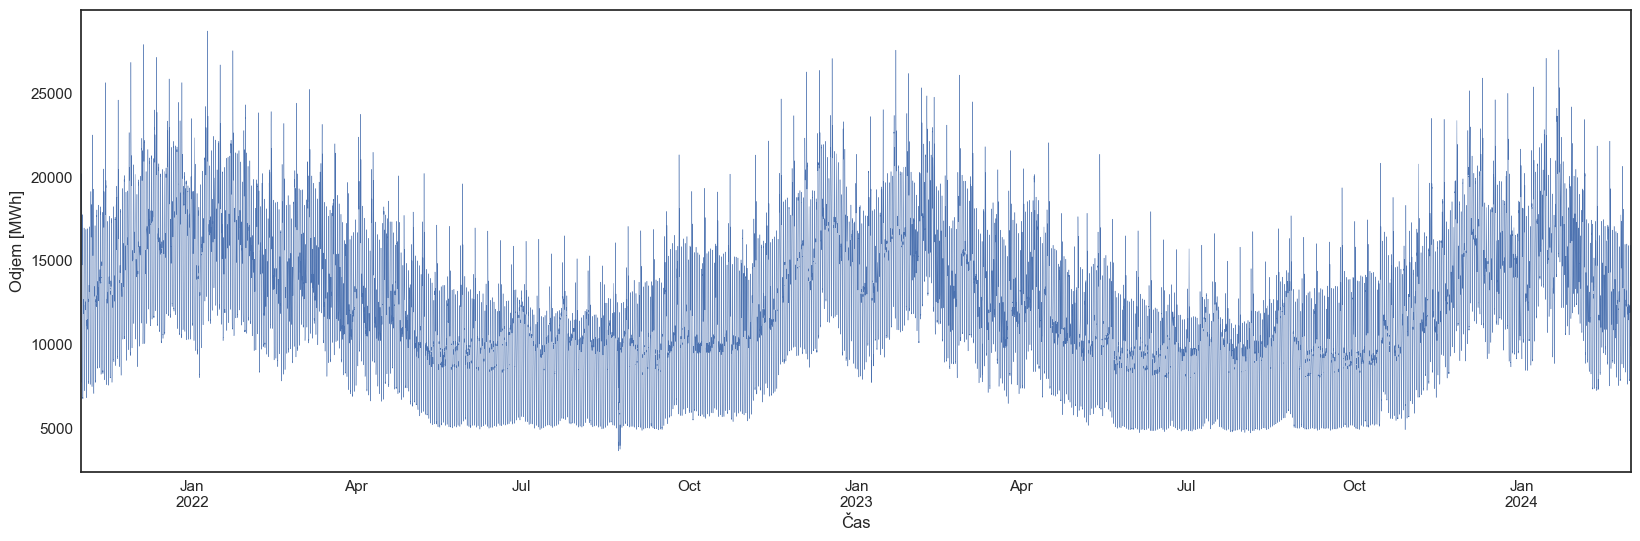

In [148]:
plt.style.use('seaborn-white')
podatki['Odjem ACT'].plot(linewidth=0.3)
# plt.title('Odjem električne energije gospodinjskih odjemalcev, 2021-2024', fontsize=20, weight='bold')
plt.xlabel('Čas')
plt.ylabel('Odjem [MWh]')

In [96]:
## Številki opis podatkov:
pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,3629.32,28736.8,12240.53023,11708.5,4167.978437


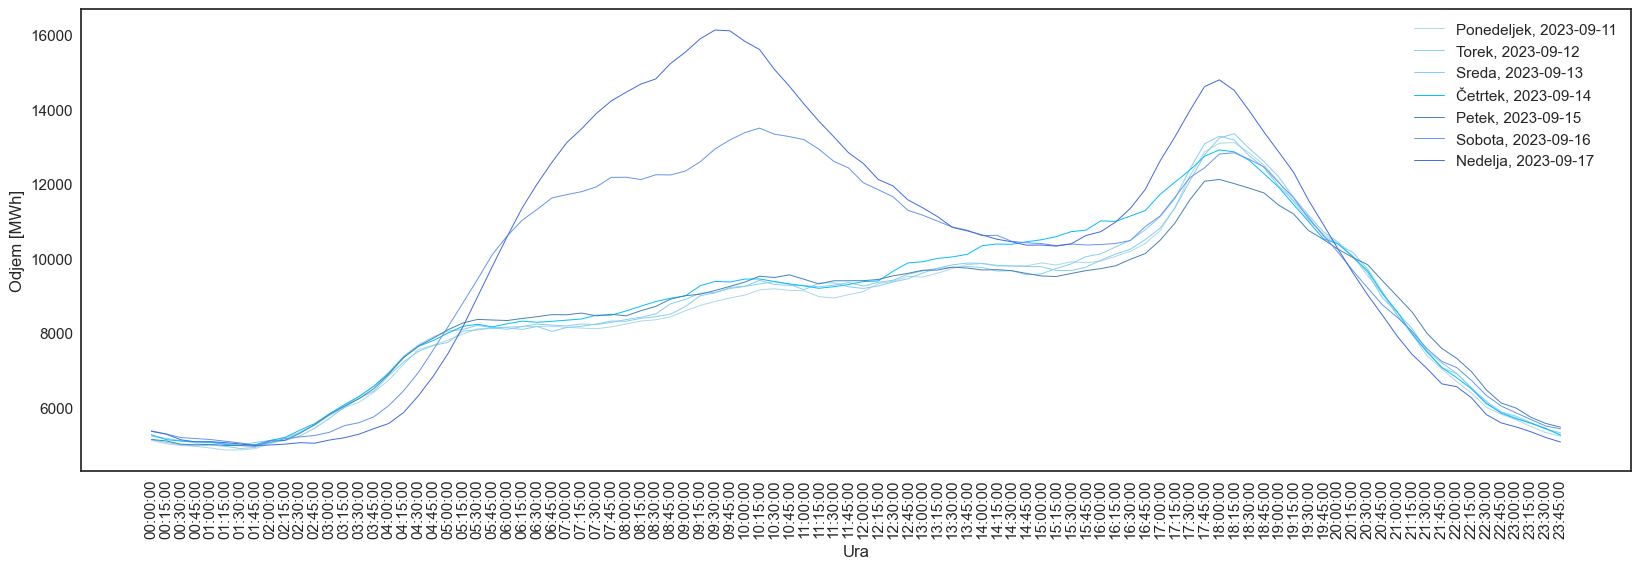

In [149]:
# podatki.loc['2023-09-11', 'Odjem ACT'].plot(linewidth=0.3)
plt.xticks(rotation = 90)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-11', 'Odjem ACT'], label='Ponedeljek, 2023-09-11', color='lightblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-12', 'Odjem ACT'], label='Torek, 2023-09-12', color='skyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-13', 'Odjem ACT'], label='Sreda, 2023-09-13', color='lightskyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-14', 'Odjem ACT'], label='Četrtek, 2023-09-14', color='deepskyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-15', 'Odjem ACT'], label='Petek, 2023-09-15', color='steelblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-16', 'Odjem ACT'], label='Sobota, 2023-09-16', color='cornflowerblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-17', 'Odjem ACT'], label='Nedelja, 2023-09-17', color='royalblue', linewidth=0.7)
# plt.title('Odjem električne energije gospodinjskih odjemalcev, drugi teden septembra 2023', fontsize=20, weight='bold')
plt.xlabel('Ura')
plt.ylabel('Odjem [MWh]')
plt.legend()

In [4]:
podatki['log return'] = np.log(podatki['Odjem ACT']/podatki['Odjem ACT'].shift(-1))
podatki = podatki.dropna()
podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,log return
DateTimeStartUTC,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.036444
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.034200
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.040203
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.021227
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,0.004812
...,...,...,...,...,...,...,...,...,...
2024-02-29 21:30:00,12529.80,6.85,7.650,0.0,0.0,2024,2,2024-02-29,0.042745
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,0.057346
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,0.048778


<AxesSubplot: xlabel='DateTimeStartUTC'>

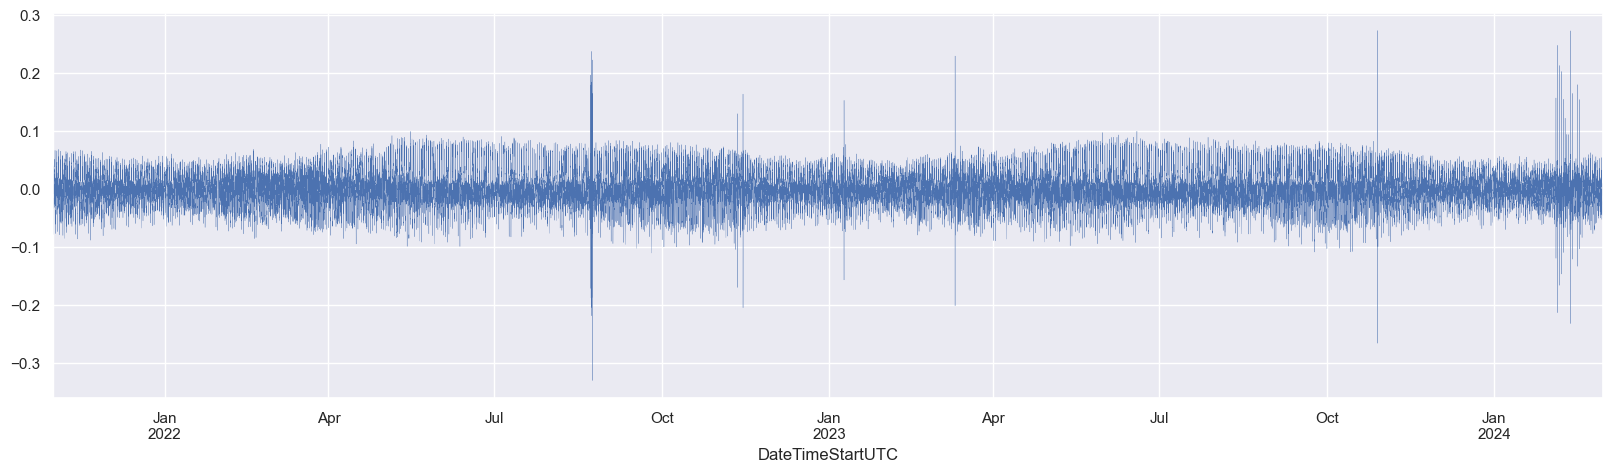

In [8]:
podatki['log return'].plot(linewidth=0.3)
# to je ful bolj stacionarno

In [9]:
from arch.unitroot import *

def preveri_stacionarnost(ts):
    print(ADF(ts).summary())
    print('\n')
    print(KPSS(ts).summary())
    print('\n')
    print(PhillipsPerron(ts).summary())

In [11]:
preveri_stacionarnost(podatki['log return'])

# vsi testi povedo, da je časovna vrsta stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -83.893
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.001
P-value                         1.000
Lags                              133
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic                -58.607
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

Text(0.5, 1.0, 'ACF na log return')

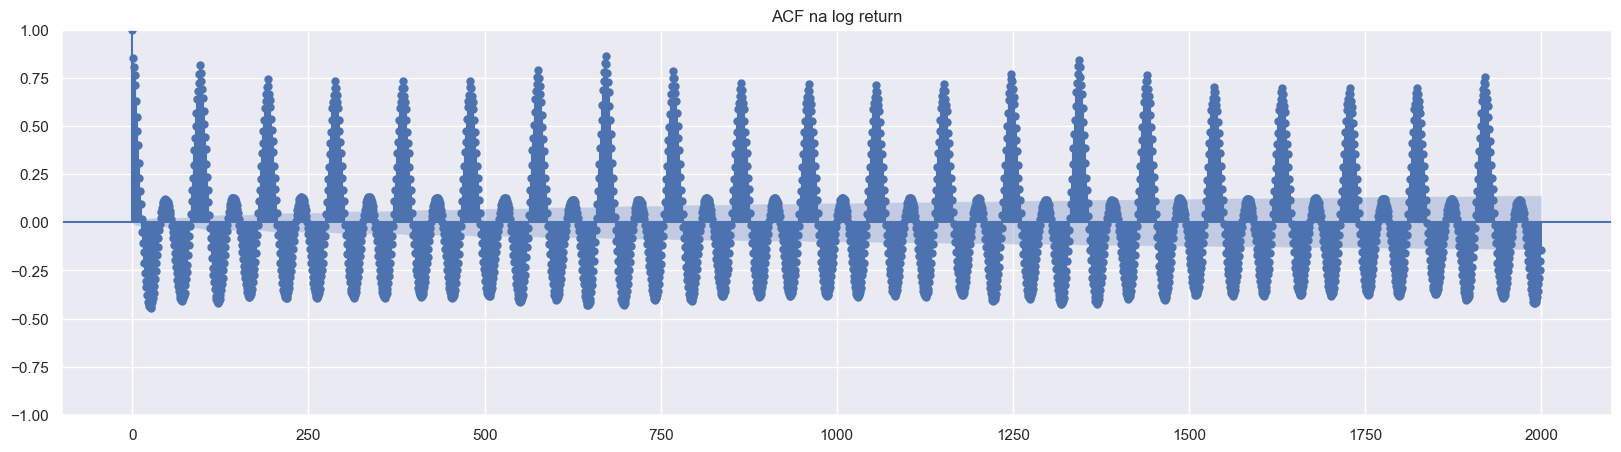

In [14]:
tsaplots.plot_acf(podatki['log return'], lags=1000)
plt.ylim(-1,1)
plt.title('ACF na log return')

# očitno je, da imamo sezonskost, zato sezonsko diferenciramo

Text(0.5, 1.0, 'Log return, ki je sezonsko diferenciran s periodo 96')

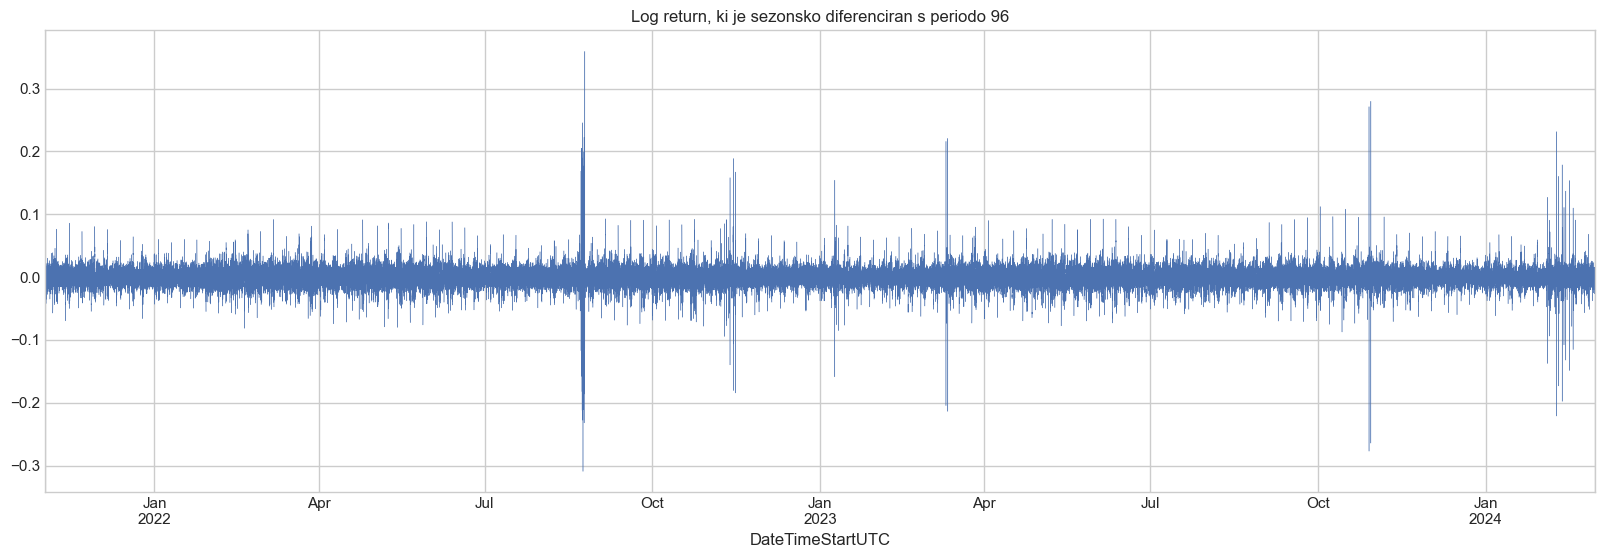

In [5]:
ts_diff = podatki['log return'].diff(periods = 96).dropna()
ts_diff.plot(linewidth=0.3) 
plt.title('Log return, ki je sezonsko diferenciran s periodo 96')

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju')

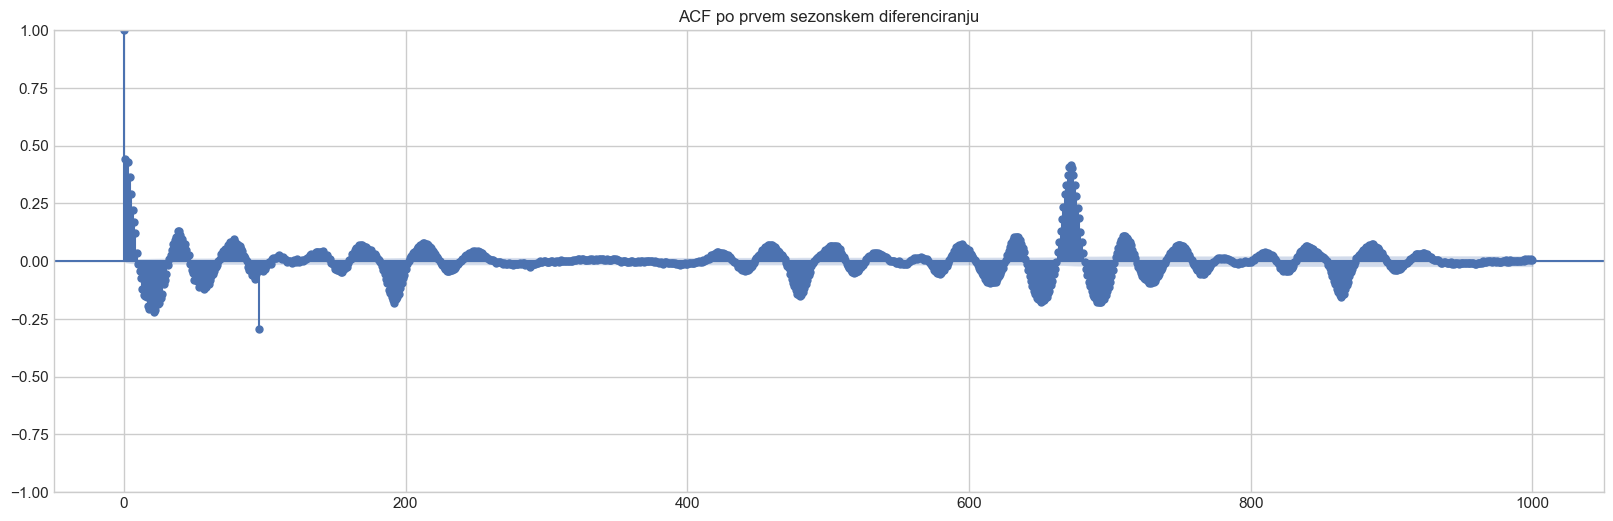

In [24]:
tsaplots.plot_acf(ts_diff, lags=1000)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju')

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, zoženo')

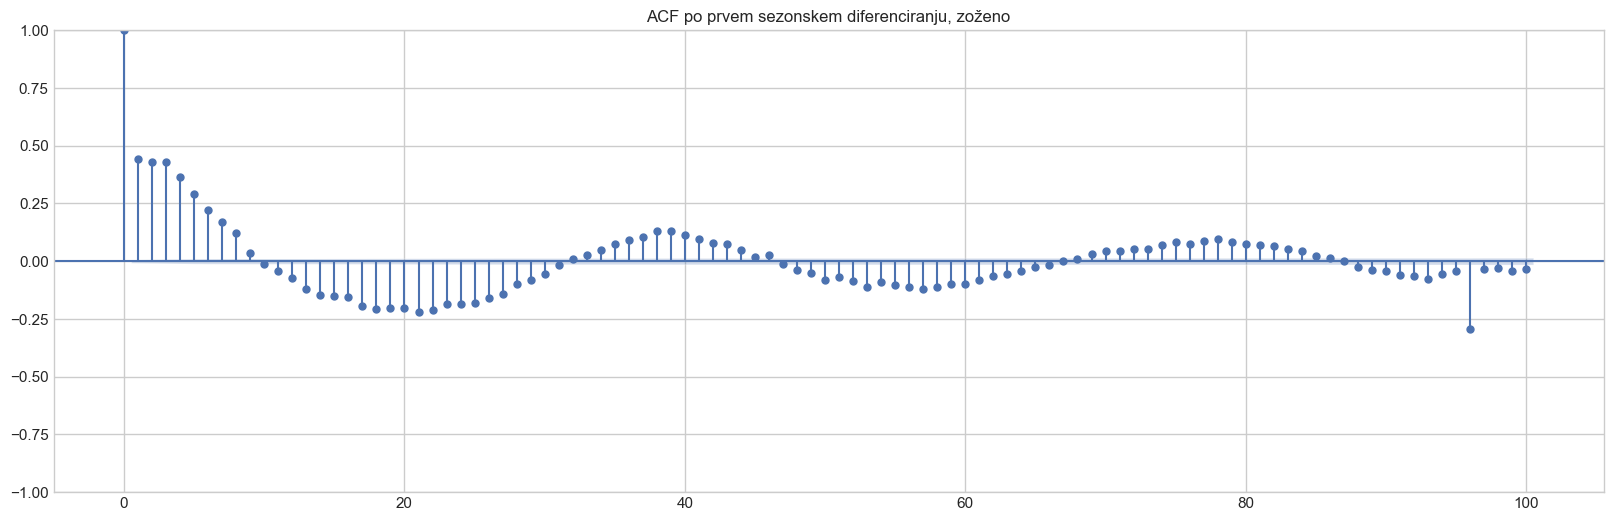

In [25]:
tsaplots.plot_acf(ts_diff, lags=100)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju, zoženo')

Text(0.5, 1.0, 'Po drugem diferenciranju')

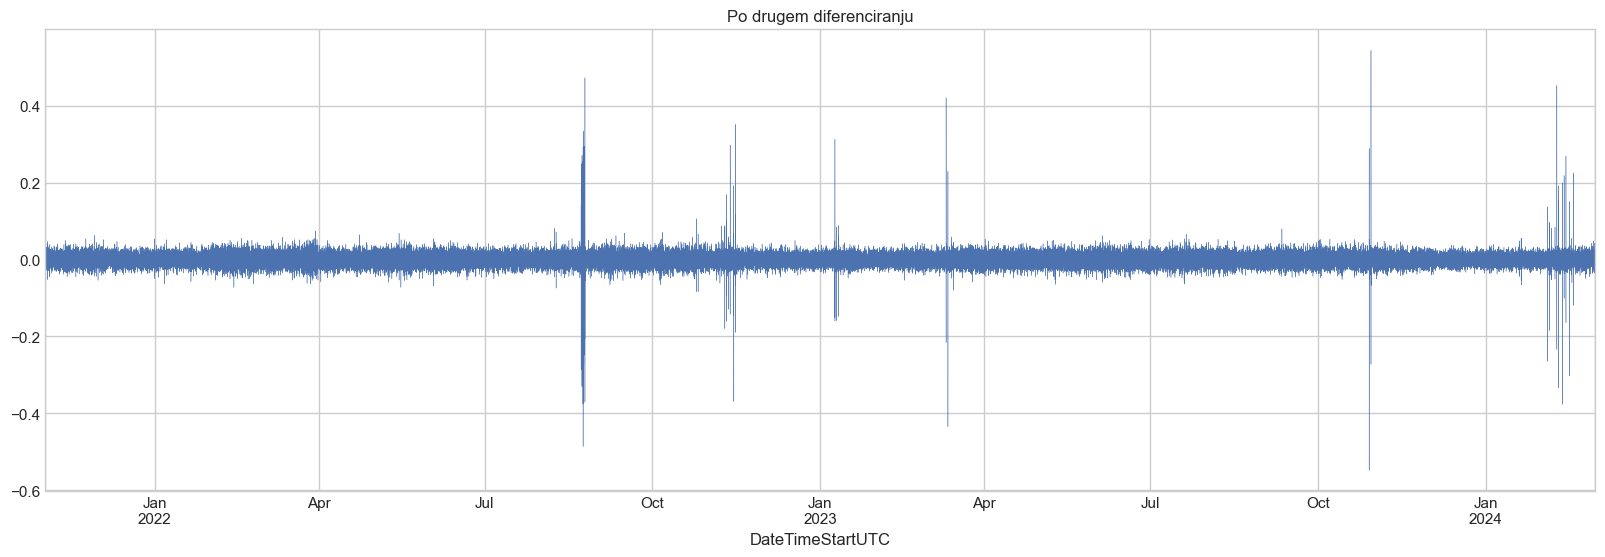

In [26]:
ts_diff_2 = ts_diff.diff().dropna()
ts_diff_2.plot(linewidth=0.3) 
plt.title('Po drugem diferenciranju')

Text(0.5, 1.0, 'ACF po drugem diferenciranju')

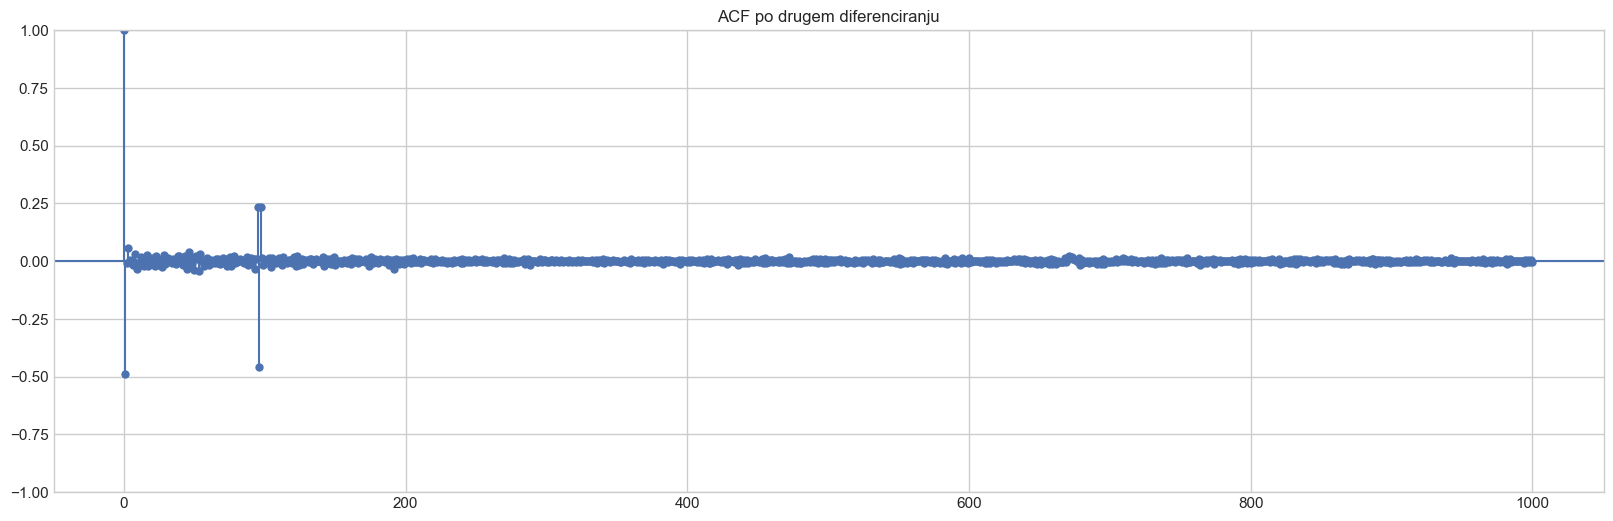

In [27]:
tsaplots.plot_acf(ts_diff_2, lags=1000)
plt.ylim(-1,1)
plt.title('ACF po drugem diferenciranju')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, zoženo')

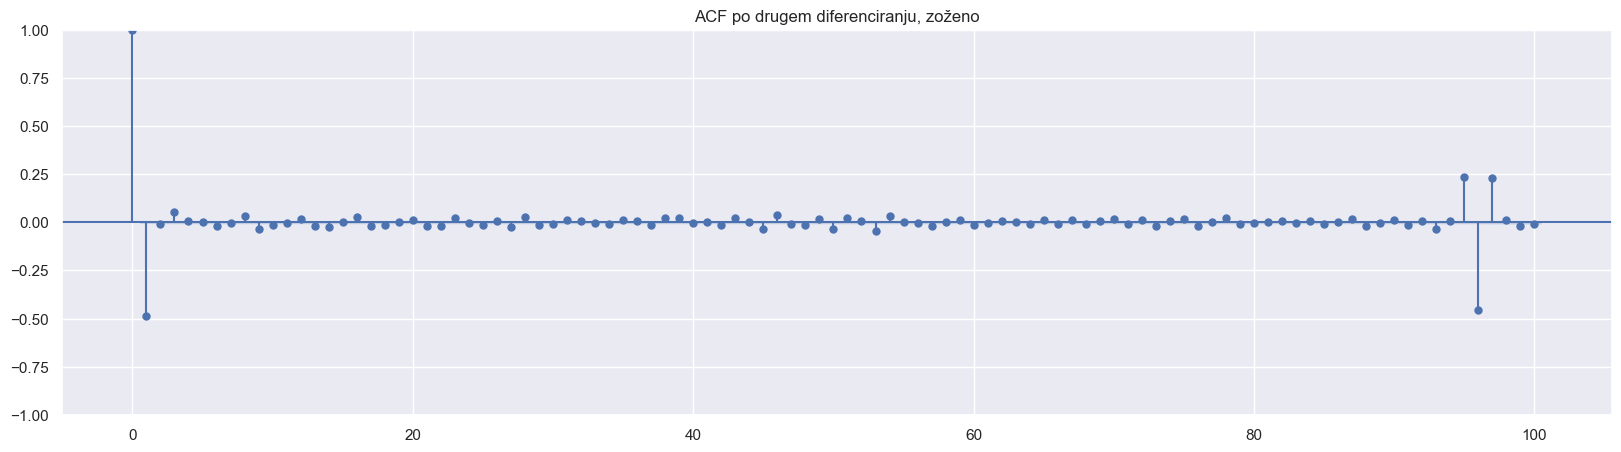

In [26]:
tsaplots.plot_acf(ts_diff_2, lags=100)
plt.ylim(-1,1)
plt.title('ACF po drugem diferenciranju, zoženo')

# q je 1 ali pa 95

Text(0.5, 1.0, 'PACF po drugem diferenciranju')

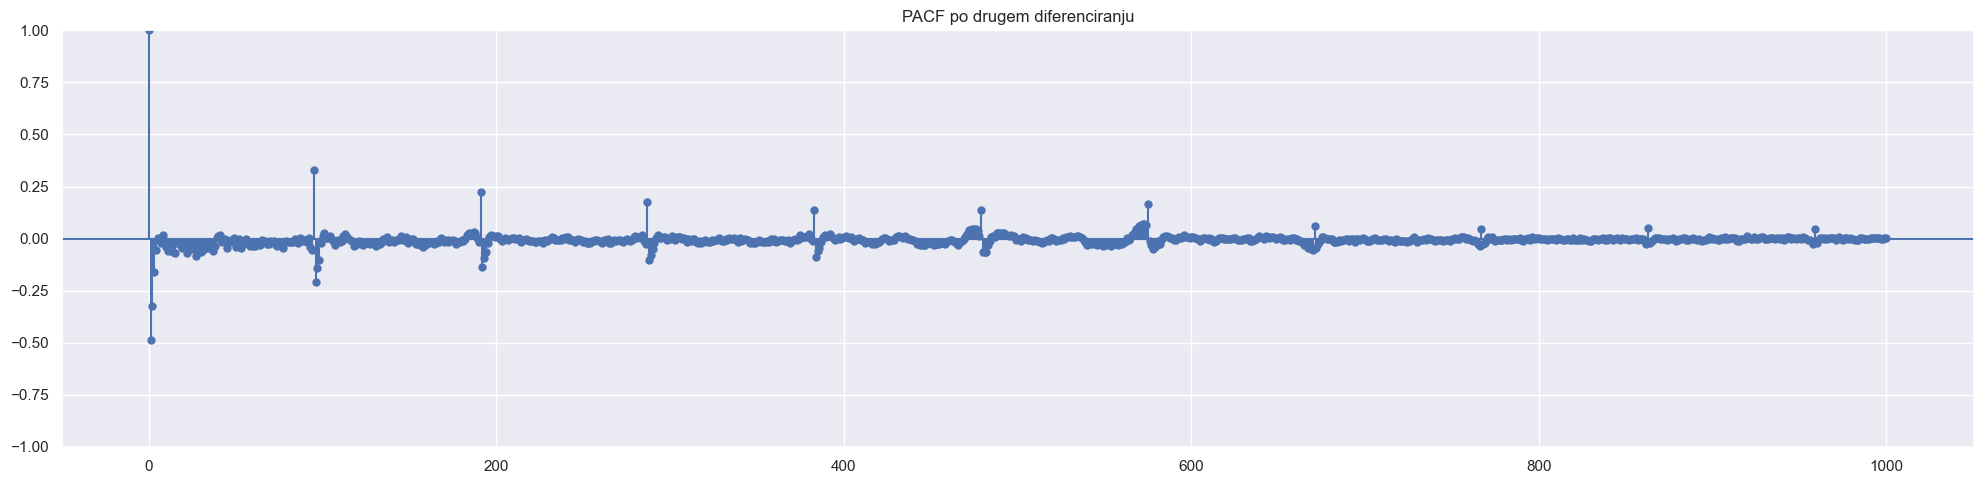

In [25]:
tsaplots.plot_pacf(ts_diff_2, lags=1000, method="ywm")
plt.ylim(-1,1)
plt.title('PACF po drugem diferenciranju')

Text(0.5, 1.0, 'PACF po drugem diferenciranju, zoženo')

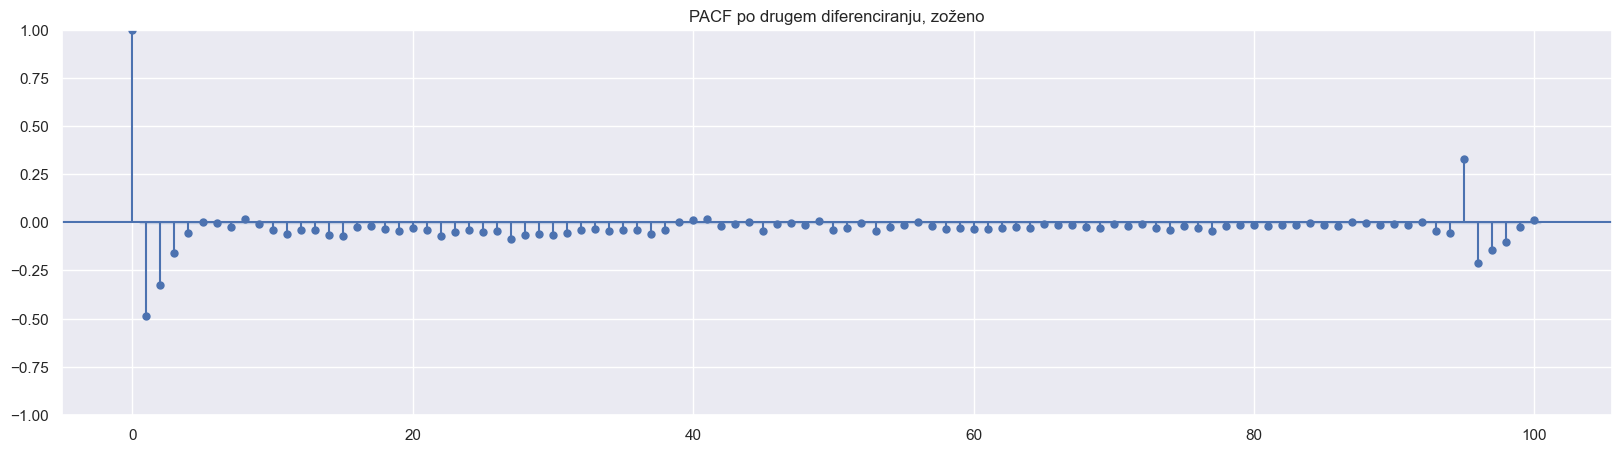

In [27]:
tsaplots.plot_pacf(ts_diff_2, lags=100, method="ywm")
plt.ylim(-1,1)
plt.title('PACF po drugem diferenciranju, zoženo')

# p je 1, 2, 3 ali 95

In [28]:
preveri_stacionarnost(ts_diff_2)

# vsi testi povedo, da je stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -64.756
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.002
P-value                         1.000
Lags                              243
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic              -1501.246
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

In [67]:
# TRAIN na 75 % (od 2021-11-01 23:00:00 do 2023-08-04 23:45:00)
# TEST na 25 %

start = 0
end = 61540

# train data:
df = podatki[(start+96):(end+96)]

train_data_log = df['log return']
train_data_diff_96 = ts_diff[(start):(end)] # !!
train_exog = df[['Temperatura FC', 'Sevanje FC']]

# test data:
df_test = podatki[(end+96):(end+96+96)]

day = '2023-08-05'
next_day = '2023-08-06'

test_data_log = df_test['log return']
test_data_diff_96 = ts_diff[end:(end+96)] # !!
test_exog = df_test[['Temperatura FC', 'Sevanje FC']]

print(train_data_diff_96)
print(train_exog)

print(test_data_diff_96)
print(test_exog)

DateTimeStartUTC
2021-11-01 23:00:00    0.001366
2021-11-01 23:15:00    0.000678
2021-11-01 23:30:00   -0.007324
2021-11-01 23:45:00   -0.004867
2021-11-02 00:00:00    0.008309
                         ...   
2023-08-04 22:45:00   -0.003885
2023-08-04 23:00:00    0.017050
2023-08-04 23:15:00   -0.009203
2023-08-04 23:30:00    0.001712
2023-08-04 23:45:00   -0.001645
Freq: 15T, Name: log return, Length: 61540, dtype: float64
                     Temperatura FC  Sevanje FC
DateTimeStartUTC                               
2021-11-01 23:00:00          10.300         0.0
2021-11-01 23:15:00          10.225         0.0
2021-11-01 23:30:00          10.150         0.0
2021-11-01 23:45:00          10.075         0.0
2021-11-02 00:00:00          10.000         0.0
...                             ...         ...
2023-08-04 22:45:00          15.925         0.0
2023-08-04 23:00:00          15.900         0.0
2023-08-04 23:15:00          15.925         0.0
2023-08-04 23:30:00          15.950         

In [92]:
# delala bom na ts_diff (torej na 1x sezonsko diferenciranih) --> d = 1 
# na koncu bom oddiferencirala in naredila inverz od log returns da pridem nazaj na originalno skalo

In [56]:
def RMSE_MAPE (podatki_OG, napoved):
    '''Funkcija RMSE_MAPE izračuna napaki RMSE in MAPE. Vrne seznam oblike [RMSE, MAPE]'''
    errors = podatki_OG - napoved
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / podatki_OG)) * 100
    return [rmse, mape]

def napoved_na_OG_skala (podatki, napoved, dan, naslednji_dan):
    '''Najprej dediferenciramo in nato naredimo inverz log returnov.'''
    napoved_ = napoved + podatki['log return'].shift(-96)[dan]
    
    start = dan + ' 00:00:00'
    end = naslednji_dan + ' 00:00:00'

    return(np.exp(napoved_ + np.log(podatki.loc[start:end, 'Odjem ACT'].shift(-1)[dan])))

def izrisi_graf_napovedi (podatki, napoved, naslov):
    '''Funkcija izrisi_graf_napovedi izriše graf napovedi'''
    plt.style.use('seaborn-whitegrid')
    plt.plot(podatki, label='Dejanski podatki', color='gray')
    plt.plot(napoved, label='Napovedani podatki', color='orangered')
    plt.title(naslov, fontsize=15)
    plt.xlabel('Čas')
    plt.ylabel('Odjem [kWh]')
    plt.legend()
    plt.show()

In [8]:
# model_1 = sm.tsa.statespace.SARIMAX(train_data_log, order=(5,1,4), seasonal_order=(0,1,0,96))
# results_1 = model_1.fit()

# # 7 min

In [94]:
# test_forecast = results_1.forecast(steps=96)


# # import math

# napoved = np.exp(test_forecast + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
# napoved

# plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='gray')
# plt.plot(napoved, label='Forecasted Data', color='orangered')
# plt.title('ARIMA Model Evaluation')
# plt.xlabel('Date')
# plt.ylabel('Odjem')
# plt.legend()
# plt.show()

In [95]:
# sarima_residuals_1 = results_1.resid
# sarima_residuals_1
# plt.plot(sarima_residuals_1)

In [96]:
# tsaplots.plot_acf(sarima_residuals_1, lags=100)
# plt.ylim(-1,1)
# plt.title('ACF SARIMA')

In [97]:
# tsaplots.plot_pacf(sarima_residuals_1, lags=100)
# plt.ylim(-1,1)
# plt.title('PACF SARIMA')

In [98]:
# # fit a GARCH(2,2) model on the residuals of the SARIMA model

# modelGARCH = arch.arch_model(sarima_residuals_1, mean='Zero', vol='Garch', p=1, q=1)
# resultGarch = modelGARCH.fit()
# forecastGARCH = resultGarch.forecast(horizon=96)


# # združimo SARIMO in GARCH
# forecast = test_forecast.mean() + forecastGARCH.variance.values[-1, :]
# forecast

# forecastDf = pd.DataFrame(forecast, index=test_forecast.index, columns=['Forecast'])
# forecastDf

# napoved_ARIMA_GARCH = np.exp(forecastDf['Forecast'] + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
# napoved_ARIMA_GARCH

# plt.style.use('seaborn-whitegrid')

# plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='gray')
# plt.plot(napoved_ARIMA_GARCH, label='Forecasted Data', color='orangered')
# plt.title('ARIMA Model Evaluation', fontsize=15)
# plt.xlabel('Date')
# plt.ylabel('Odjem')
# plt.legend()
# plt.show()



In [99]:
# resultGarch.summary()

In [167]:
# SARIMA 
[RMSE_SARIMA, MAPE_SARIMA] = RMSE_MAPE(podatki.loc['2023-04-01', 'Odjem ACT'] , napoved)

[RMSE_SARIMA_GARCH, MAPE_SARIMA_GARCH] = RMSE_MAPE(podatki.loc['2023-04-01', 'Odjem ACT'] , napoved_ARIMA_GARCH)

print(RMSE_SARIMA, MAPE_SARIMA)
print(RMSE_SARIMA_GARCH, MAPE_SARIMA_GARCH)


345.93778404627676 2.10478657820608
390.4208141274457 2.5715234851461335


In [16]:
model_2 = sm.tsa.statespace.SARIMAX(train_data_log, order=(5,1,4), exog = train_exog)
results_2 = model_2.fit()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


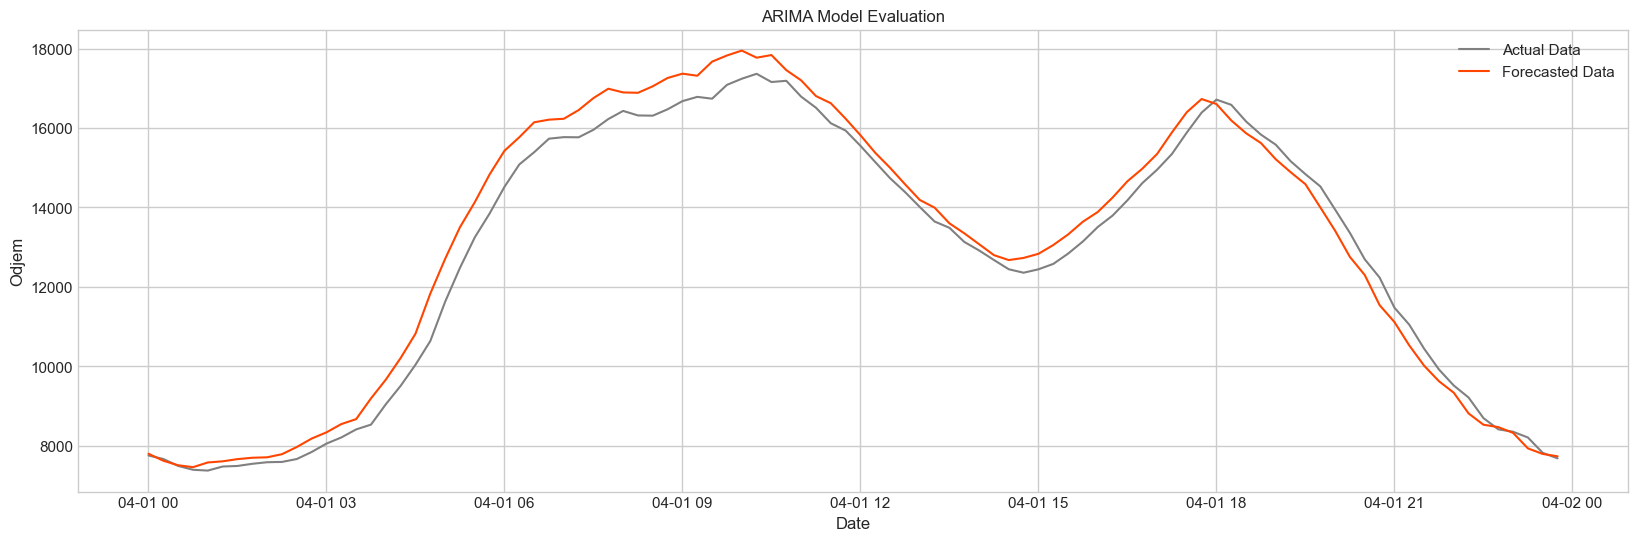

In [18]:
test_forecast_2 = results_2.forecast(steps=96, exog=test_exog)

# import math

napoved_2 = np.exp(test_forecast_2 + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
napoved_2

plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='gray')
plt.plot(napoved_2, label='Forecasted Data', color='orangered')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()


In [29]:
def ARIMA_no_exog(p, d, q, train):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q))
    results = model.fit()
    return results

def ARIMA_exog(p, d, q, train, exog):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), exog = exog)
    results = model.fit()
    return results

def GARCH (residuali, p, q):
    model = arch.arch_model(residuali, mean='Zero', vol='Garch', p=p, q=q)
    results = model.fit()
    return results

def forecast_no_exog (results, steps):
    return results.forecast(steps)

def forecast_exog (results, steps, exog):
    return results.forecast(steps=steps, exog=exog)

In [10]:
results_1 = ARIMA_exog(1, 1, 0, train_data_diff_96, train_exog)
# 13.2s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
forecast_1 = forecast_exog(results_1, 96, test_exog)
# na OG skalo:
forecast_OG_1 = napoved_na_OG_skala(podatki, forecast_1, day, next_day)

errors_1 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_1)
errors_1

[157.0568199526522, 1.1051986523984216]

In [11]:
results_2 = ARIMA_exog(0, 1, 1, train_data_diff_96, train_exog)
# 19.4s

In [35]:
forecast_2 = forecast_exog(results_2, 96, test_exog)
# na OG skalo:
forecast_OG_2 = napoved_na_OG_skala(podatki, forecast_2, day, next_day)

errors_2 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_2)
errors_2

[156.45647377845617, 1.1021269871265158]

In [12]:
results_3 = ARIMA_exog(1, 1, 1, train_data_diff_96, train_exog)
# 42.0s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
forecast_3 = forecast_exog(results_3, 96, test_exog)
# na OG skalo:
forecast_OG_3 = napoved_na_OG_skala(podatki, forecast_3, day, next_day)

errors_3 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_3)
errors_3

[156.47263873589245, 1.1022190066927853]

In [13]:
results_4 = ARIMA_exog(2, 1, 2, train_data_diff_96, train_exog)
# 25.6s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
forecast_4 = forecast_exog(results_4, 96, test_exog)
# na OG skalo:
forecast_OG_4 = napoved_na_OG_skala(podatki, forecast_4, day, next_day)

errors_4 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_4)
errors_4

[156.98487656580875, 1.1048979316203285]

In [14]:
results_5 = ARIMA_exog(3, 1, 2, train_data_diff_96, train_exog)
# 26.4s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
forecast_5 = forecast_exog(results_5, 96, test_exog)
# na OG skalo:
forecast_OG_5 = napoved_na_OG_skala(podatki, forecast_5, day, next_day)

errors_5 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_5)
errors_5

[156.923462520095, 1.1046522982332048]

In [15]:
results_6 = ARIMA_exog(4, 1, 3, train_data_diff_96, train_exog)
# 3m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
forecast_6 = forecast_exog(results_6, 96, test_exog)
# na OG skalo:
forecast_OG_6 = napoved_na_OG_skala(podatki, forecast_6, day, next_day)

errors_6 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_6)
errors_6

[258.43943099736185, 2.059322726065242]

In [16]:
results_7 = ARIMA_exog(5, 1, 4, train_data_diff_96, train_exog)
# 2m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [40]:
forecast_7 = forecast_exog(results_7, 96, test_exog)
# na OG skalo:
forecast_OG_7 = napoved_na_OG_skala(podatki, forecast_7, day, next_day)

errors_7 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_7)
errors_7

[154.22758429144432, 1.0958646270979264]

In [17]:
results_8 = ARIMA_exog(5, 1, 5, train_data_diff_96, train_exog)
# 2m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [41]:
forecast_8 = forecast_exog(results_8, 96, test_exog)
# na OG skalo:
forecast_OG_8 = napoved_na_OG_skala(podatki, forecast_8, day, next_day)

errors_8 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_8)
errors_8

[153.92291782014985, 1.0951634259416103]

In [18]:
results_9 = ARIMA_exog(4, 1, 5, train_data_diff_96, train_exog)
# 1m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
forecast_9 = forecast_exog(results_9, 96, test_exog)
# na OG skalo:
forecast_OG_9 = napoved_na_OG_skala(podatki, forecast_9, day, next_day)

errors_9 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_9)
errors_9

[156.83390557235174, 1.1041397908825865]

In [19]:
results_10 = ARIMA_exog(6, 1, 5, train_data_diff_96, train_exog)
# 4m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
forecast_10 = forecast_exog(results_10, 96, test_exog)
# na OG skalo:
forecast_OG_10 = napoved_na_OG_skala(podatki, forecast_10, day, next_day)

errors_10 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_10)
errors_10

[153.91687726258925, 1.0952189746672252]

In [20]:
results_11 = ARIMA_exog(6, 1, 6, train_data_diff_96, train_exog) 
# 4m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [44]:
forecast_11 = forecast_exog(results_11, 96, test_exog)
# na OG skalo:
forecast_OG_11 = napoved_na_OG_skala(podatki, forecast_11, day, next_day)

errors_11 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_11)
errors_11

[153.97906945247192, 1.0959353955469662]

In [21]:
results_12 = ARIMA_exog(5, 1, 6, train_data_diff_96, train_exog) 
# 3m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [45]:
forecast_12 = forecast_exog(results_12, 96, test_exog)
# na OG skalo:
forecast_OG_12 = napoved_na_OG_skala(podatki, forecast_12, day, next_day)

errors_12 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_12)
errors_12

[154.02346024845522, 1.0959107330636153]

In [49]:
pd.DataFrame([
    ['SARIMA(1,1,0)(0,1,0)[96]', results_1.aic, errors_1[0], errors_1[1]], 
    ['SARIMA(0,1,1)(0,1,0)[96]', results_2.aic, errors_2[0], errors_2[1]], 
    ['SARIMA(1,1,1)(0,1,0)[96]', results_3.aic, errors_3[0], errors_3[1]], 
    ['SARIMA(2,1,1)(0,1,0)[96]', results_4.aic, errors_4[0], errors_4[1]], 
    ['SARIMA(3,1,2)(0,1,0)[96]', results_5.aic, errors_5[0], errors_5[1]],
    ['SARIMA(4,1,3)(0,1,0)[96]', results_6.aic, errors_6[0], errors_6[1]], 
    ['SARIMA(5,1,4)(0,1,0)[96]', results_7.aic, errors_7[0], errors_7[1]], 
    ['SARIMA(5,1,5)(0,1,0)[96]', results_8.aic, errors_8[0], errors_8[1]], 
    ['SARIMA(4,1,5)(0,1,0)[96]', results_9.aic, errors_9[0], errors_9[1]], 
    ['SARIMA(6,1,5)(0,1,0)[96]', results_10.aic, errors_11[0], errors_10[1]], 
    ['SARIMA(6,1,6)(0,1,0)[96]', results_11.aic, errors_11[0], errors_11[1]], 
    ['SARIMA(5,1,6)(0,1,0)[96]', results_12.aic, errors_11[0], errors_12[1]]
],
columns=('Model', 'AIC', 'RMSE', 'MAPE'))

# Po AIC: najboljši je SARIMA(4,1,5) --> results_9
# Po RMSE in MAPE: sarima(5,1,5) --> results_8

,Model,AIC,RMSE,MAPE
0,"SARIMA(1,1,0)(0,1,0)[96]",-338588.046330,157.056820,1.105199
1,"SARIMA(0,1,1)(0,1,0)[96]",-346718.519174,156.456474,1.102127
2,"SARIMA(1,1,1)(0,1,0)[96]",-346768.583304,156.472639,1.102219
3,"SARIMA(2,1,1)(0,1,0)[96]",-347555.506685,156.984877,1.104898
4,"SARIMA(3,1,2)(0,1,0)[96]",-347573.393767,156.923463,1.104652
5,"SARIMA(4,1,3)(0,1,0)[96]",-278981.697958,258.439431,2.059323
6,"SARIMA(5,1,4)(0,1,0)[96]",-345287.412681,154.227584,1.095865
7,"SARIMA(5,1,5)(0,1,0)[96]",-345310.104621,153.922918,1.095163
8,"SARIMA(4,1,5)(0,1,0)[96]",-347619.304177,156.833906,1.104140
9,"SARIMA(6,1,5)(0,1,0)[96]",-345325.841533,153.979069,1.095219


In [55]:
import warnings
warnings.warn = lambda *a, **kw: False

pd.DataFrame([
    ['SARIMA(4,1,5)(0,1,0)[96]-GARCH(p,q)', 
     results_9.aic,
     GARCH(results_9.resid, 1, 1).aic,
     GARCH(results_9.resid, 1, 2).aic,
     GARCH(results_9.resid, 2, 1).aic,
     GARCH(results_9.resid, 2, 2).aic,
     GARCH(results_9.resid, 1, 3).aic,
     GARCH(results_9.resid, 3, 1).aic
     ], 
],
columns=('AIC', '(0, 0)', '(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)', '(1, 3)', '(3, 1)'))

Iteration:      1,   Func. Count:      4,   Neg. LLF: -182880.2239040917
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -182880.22383275238
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33458700898.928905
Iteration:      2,   Func. Count:     12,   Neg. LLF: -183032.1089654104
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183032.10895629268
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -182721.28834071316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -182721.28836649185
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -182926.83652269363
Optimizat

,AIC,"(0, 0)","(1, 1)","(1, 2)","(2, 1)","(2, 2)","(1, 3)","(3, 1)"
0,"SARIMA(4,1,5)(0,1,0)[96]-GARCH(p,q)",-347619.304177,-365754.447666,-366056.217913,-365434.576733,-365843.67319,-366134.33453,-365252.576424


In [ ]:
def SARIMA_GARCH_forecast(podatki, train_data, train_exog, test_data, test_exog, day, next_day):
    results = ARIMA_exog(4, 1, 5, train_data, train_exog)
    forecast = forecast_exog(results, 96, test_exog)

    results_GARCH = GARCH(results.resid, 1, 3)
    forecastGARCH = results_GARCH.forecast(horizon=96)
    forecast_ = forecast.mean() + forecastGARCH.variance.values[-1, :]
    forecastDf = pd.DataFrame(forecast_, index=forecast.index, columns=['Forecast'])
    forecast_OG = napoved_na_OG_skala(podatki, forecastDf['Forecast'], day, next_day)

    return forecast_OG

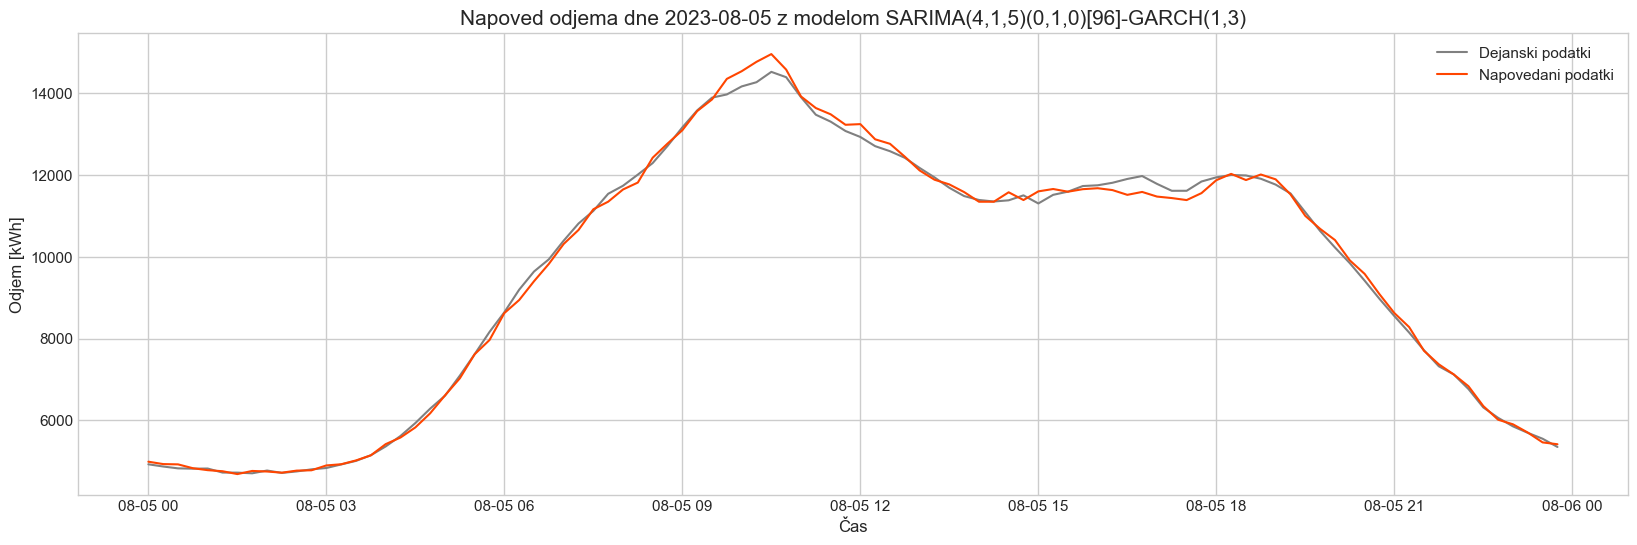

In [61]:
forecast_AG_1 = SARIMA_GARCH_forecast(podatki, train_data_diff_96, train_exog, test_data_diff_96, test_exog, day, next_day)    
izrisi_graf_napovedi(podatki.loc[day, 'Odjem ACT'], forecast_AG_1, 'Napoved odjema dne 2023-08-05 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -221174.10387081993
Optimization terminated successfully    (Exit mode 0)
            Current function value: -221174.10393972343
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


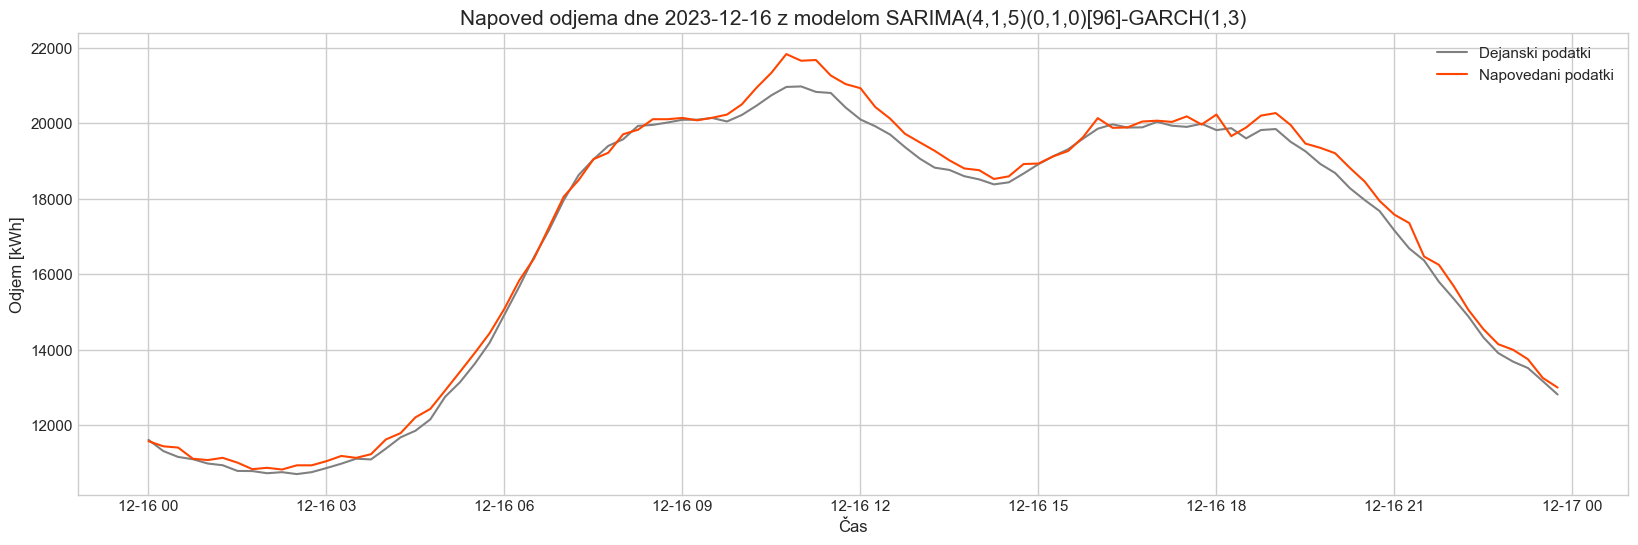

In [85]:
train_data_diff_96_2 = ts_diff['2021-11-02':'2023-12-15'] 
train_exog_2 = podatki.loc['2021-11-02':'2023-12-15', ['Temperatura FC', 'Sevanje FC']]
day_2 = '2023-12-16'
next_day_2 = '2023-12-17'
test_data_diff_96_2 = ts_diff[day_2] 
test_exog_2 = podatki.loc[day_2, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_2 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_2, train_exog_2, test_data_diff_96_2, test_exog_2, day_2, next_day_2)    
izrisi_graf_napovedi(podatki.loc[day_2, 'Odjem ACT'], forecast_AG_2, 'Napoved odjema dne 2023-12-16 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -238136.25654619688
Optimization terminated successfully    (Exit mode 0)
            Current function value: -238136.25662460565
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


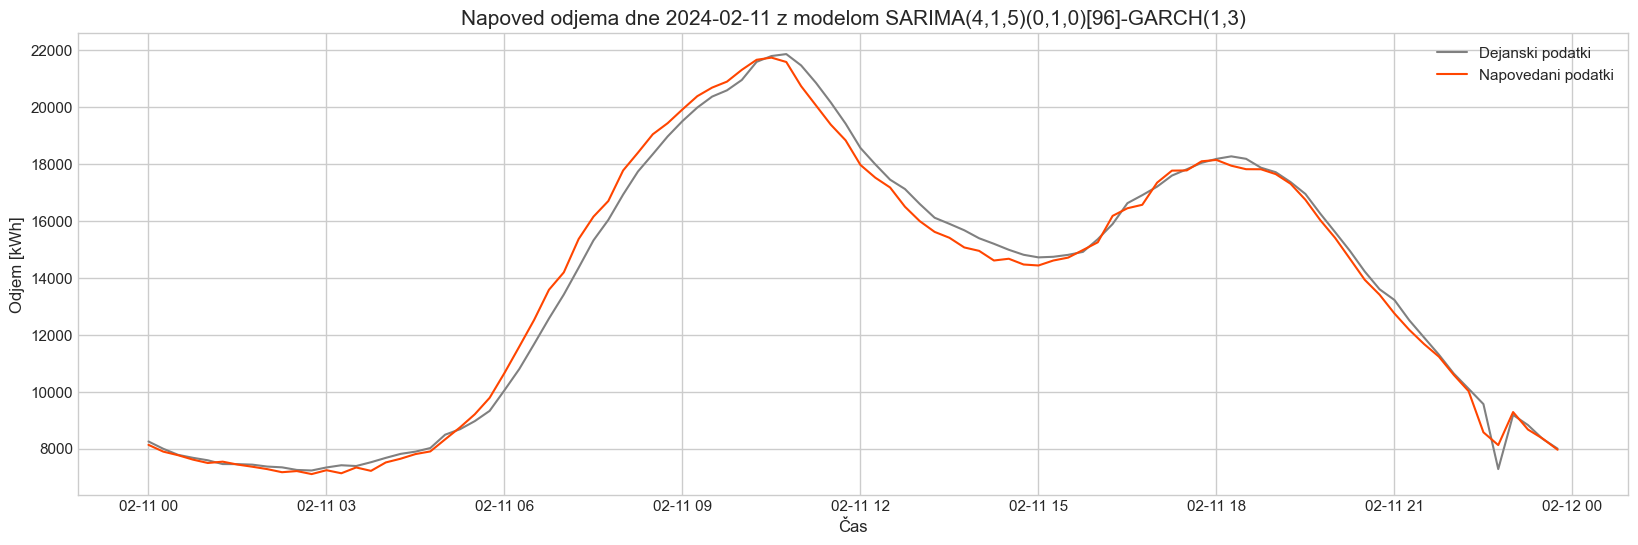

In [86]:
train_data_diff_96_3 = ts_diff['2021-11-02':'2024-02-10'] 
train_exog_3 = podatki.loc['2021-11-02':'2024-02-10', ['Temperatura FC', 'Sevanje FC']]
day_3 = '2024-02-11'
next_day_3 = '2024-02-12'
test_data_diff_96_3 = ts_diff[day_3] 
test_exog_3 = podatki.loc[day_3, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_3 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_3, train_exog_3, test_data_diff_96_3, test_exog_3, day_3, next_day_3)    
izrisi_graf_napovedi(podatki.loc[day_3, 'Odjem ACT'], forecast_AG_3, 'Napoved odjema dne 2024-02-11 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -238272.4970987809
Optimization terminated successfully    (Exit mode 0)
            Current function value: -238272.49717485814
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


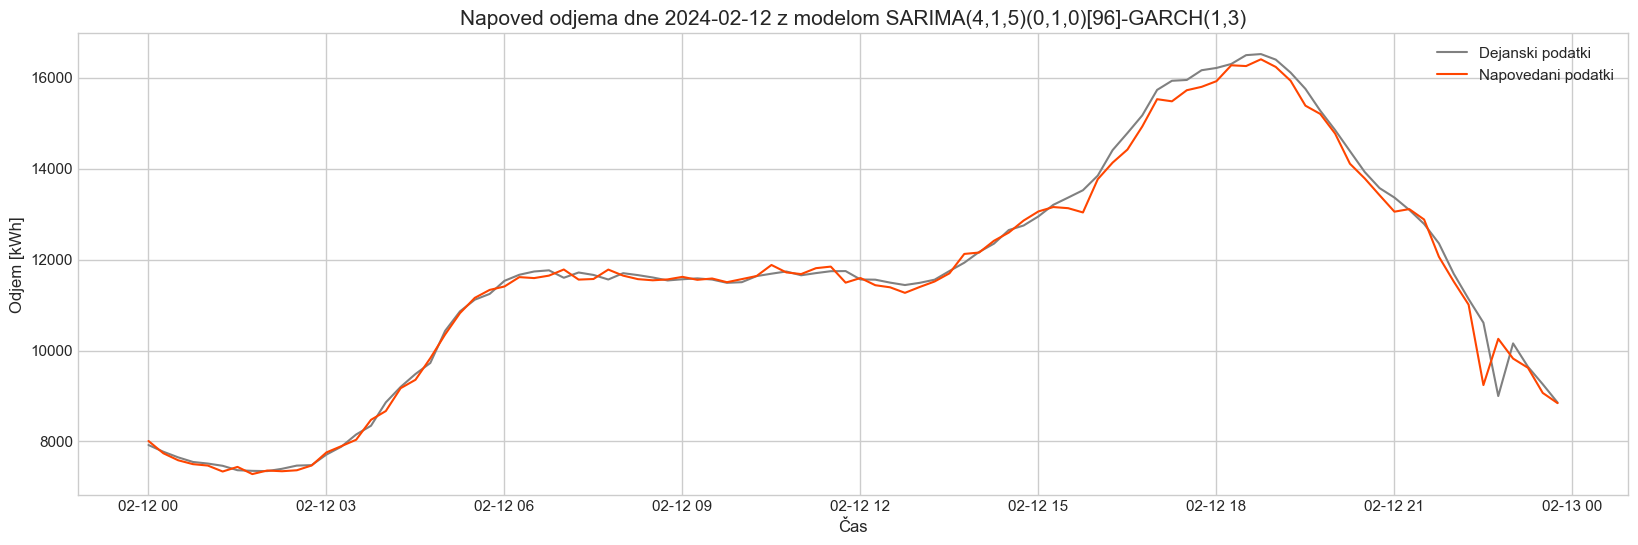

In [87]:
train_data_diff_96_4 = ts_diff['2021-11-02':'2024-02-11'] 
train_exog_4 = podatki.loc['2021-11-02':'2024-02-11', ['Temperatura FC', 'Sevanje FC']]
day_4 = '2024-02-12'
next_day_4 = '2024-02-13'
test_data_diff_96_4 = ts_diff[day_4] 
test_exog_4 = podatki.loc[day_4, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_4 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_4, train_exog_4, test_data_diff_96_4, test_exog_4, day_4, next_day_4)    
izrisi_graf_napovedi(podatki.loc[day_4, 'Odjem ACT'], forecast_AG_4, 'Napoved odjema dne 2024-02-12 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -157149.2344721602
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157149.23456257922
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


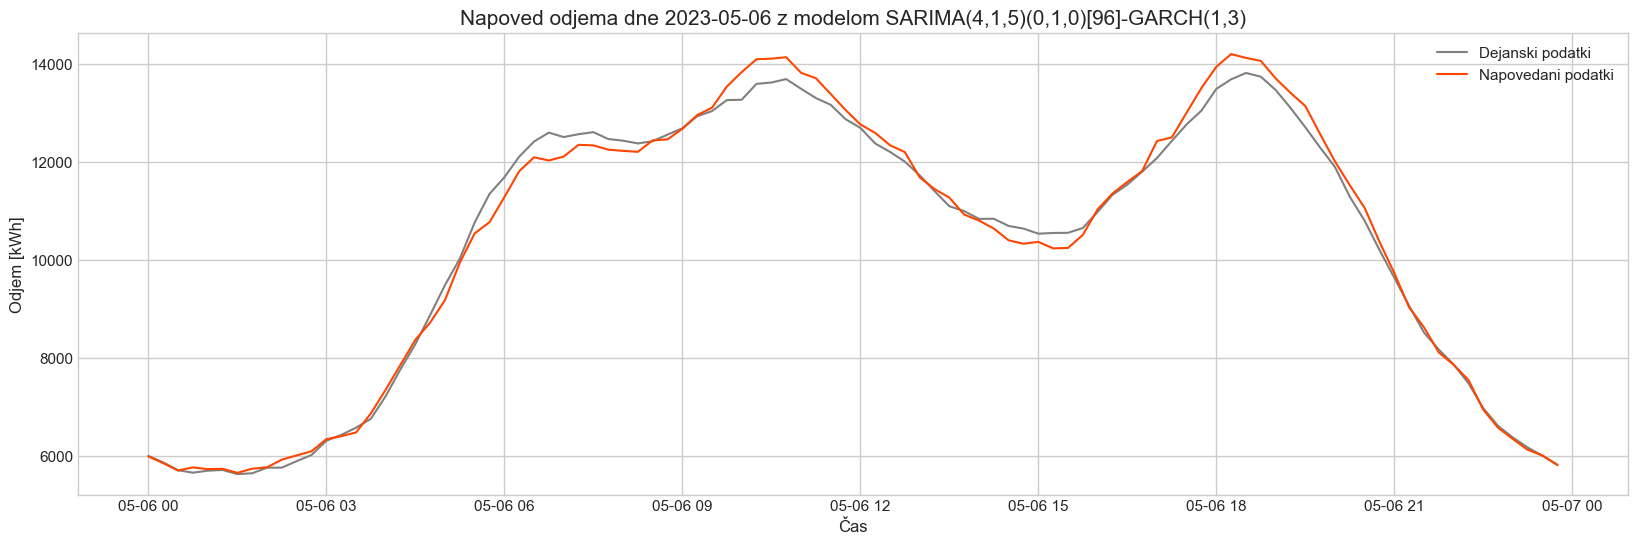

In [88]:
train_data_diff_96_5 = ts_diff['2021-11-02':'2023-05-05'] 
train_exog_5 = podatki.loc['2021-11-02':'2023-05-05', ['Temperatura FC', 'Sevanje FC']]
day_5 = '2023-05-06'
next_day_5 = '2023-05-07'
test_data_diff_96_5 = ts_diff[day_5] 
test_exog_5 = podatki.loc[day_5, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_5 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_5, train_exog_5, test_data_diff_96_5, test_exog_5, day_5, next_day_5)    
izrisi_graf_napovedi(podatki.loc[day_5, 'Odjem ACT'], forecast_AG_5, 'Napoved odjema dne 2023-05-06 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')